# Predeict heatwaves

Belgium defines a heat wave as a period of at least five consecutive days in which the maximum temperature  exceeds 25 °C. During this period the maximum temperature must exceed 30 °C for at least three days. Based on this defination, we can predict the occurance of heatwaves by predicting temperature.

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import warnings

In [3]:
warnings.filterwarnings('ignore')

## Predicting tomorrow's temperature

In [4]:
#import data
df_tem = pd.read_csv('https://github.com/hongdoudahongdou/MDA/blob/main/data/df_tem.csv?raw=true')
df_tem.set_index('time', inplace=True)
ts=df_tem['tmax']
ts

time
2022-06-30    16.0
2022-07-01    20.2
2022-07-02    22.3
2022-07-03    20.3
2022-07-04    20.7
              ... 
2023-06-26    21.0
2023-06-27    20.0
2023-06-28    24.0
2023-06-29    20.0
2023-06-30    21.0
Name: tmax, Length: 366, dtype: float64

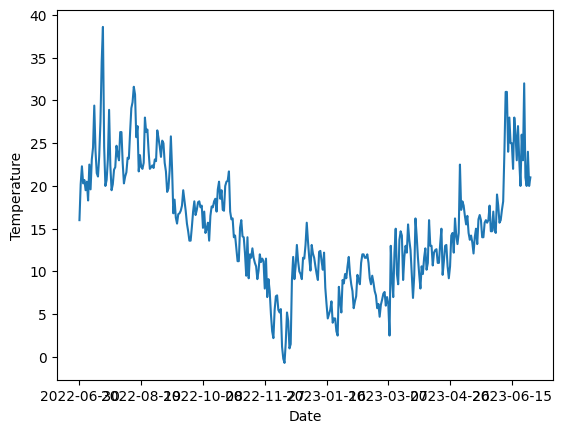

In [5]:
# Plot the data
ts.plot()
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.show()

The plot seems not stationary.

## Test for Stationarity

In [6]:
#H0: It is non stationary
#H1: It is stationary

def adfuller_test(ts):
    result=adfuller(ts)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary") 
adfuller_test(ts)

ADF Test Statistic : -1.7901421508541837
p-value : 0.38536670844167964
#Lags Used : 5
Number of Observations Used : 360
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


The ts is not stationary which suggests we may need first differecing.

In [7]:
delta_ts = ts - ts.shift(1)
delta_ts

time
2022-06-30     NaN
2022-07-01     4.2
2022-07-02     2.1
2022-07-03    -2.0
2022-07-04     0.4
              ... 
2023-06-26   -11.0
2023-06-27    -1.0
2023-06-28     4.0
2023-06-29    -4.0
2023-06-30     1.0
Name: tmax, Length: 366, dtype: float64

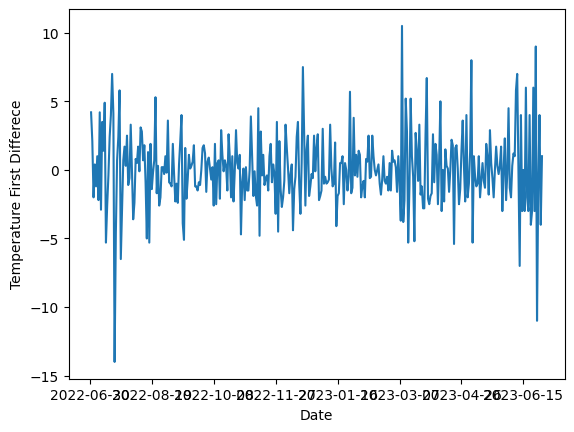

In [8]:
# Plot the delta_ts
delta_ts.plot()
plt.ylabel('Temperature First Differece')
plt.xlabel('Date')
plt.show()

The first difference seems stationary.

In [9]:
adfuller_test(delta_ts.dropna())

ADF Test Statistic : -13.464632980742754
p-value : 3.475794835198944e-25
#Lags Used : 3
Number of Observations Used : 361
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## ACF&PACF plot

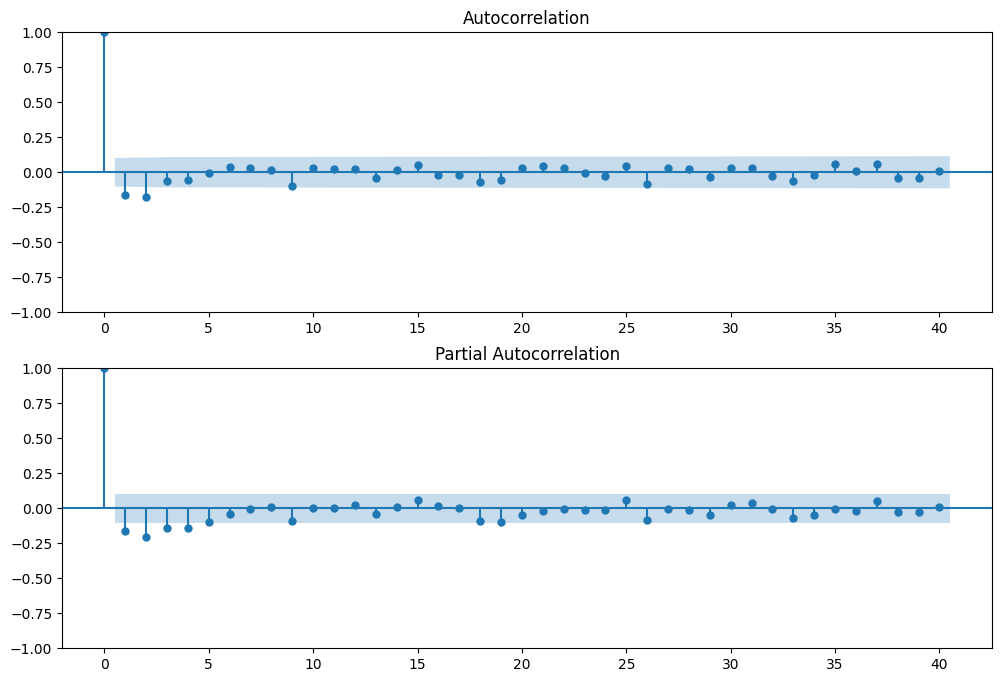

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(delta_ts.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(delta_ts.dropna(),lags=40,ax=ax2)

In [11]:
ARIMA_214=ARIMA(ts,order=(2,1,4))
ARIMA_214.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   tmax   No. Observations:                  366
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -855.997
Date:                Sat, 12 Aug 2023   AIC                           1725.994
Time:                        14:12:16   BIC                           1753.294
Sample:                    06-30-2022   HQIC                          1736.843
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6148      0.017     36.708      0.000       0.582       0.648
ar.L2         -0.9831      0.015    -63.557      0.000      -1.013      -0.953
ma.L1         -0.8925      0.036    -24.637      0.000      -0.964      -0.822
ma.L2          0.9234      0.064     14.511      0.000       0.799       1.048
ma.L3         -0.1628      0.056     -2.896      0.004      -0.273      -0.053
ma.L4         -0.2416      0.046     -5.232      0.000      -0.332      -0.151
sigma2         6.3232      0.355     17.810      0.000       5.627       7.019
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                69.58
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.49
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It seems that a ARIMA(2,1,4) model may suit our data well, we then check this by AIC.

## Choose the best ARIMA model

In [12]:
best_model = None
best_aic = float('inf')
for p in range(5):
    for q in range(5):
        try:
            model=ARIMA(ts,order=(p,1,q))
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_model = model_fit
                best_aic = model_fit.aic
        except:
            continue

print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   tmax   No. Observations:                  366
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -858.743
Date:                Sat, 12 Aug 2023   AIC                           1725.485
Time:                        14:12:24   BIC                           1741.085
Sample:                    06-30-2022   HQIC                          1731.685
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4761      0.097      4.926      0.000       0.287       0.666
ar.L2         -0.1032      0.058     -1.764      0.078      -0.218       0.011
ma.L1         -0.7380      0.092     -8.028      0.0

ARIMA(2,1,1) model has a slightly lower AIC. So we choose this relatively simple model to avoid overfitting.

<AxesSubplot:xlabel='time'>

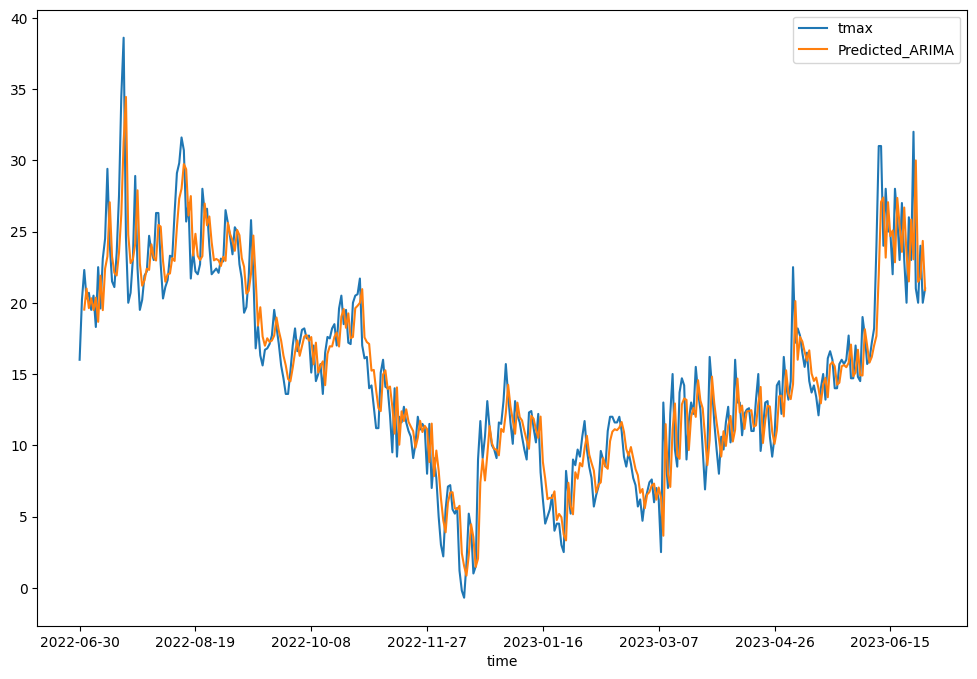

In [13]:
results=ARIMA(ts,order=(2,1,1)).fit()
df_tem['Predicted_ARIMA']=results.predict(start=2,end=365)
df_tem[['tmax','Predicted_ARIMA']].plot(figsize=(12,8))

## Predicting the temperature a week from now

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [17]:
#import data
df_tem7 = pd.read_csv('https://github.com/hongdoudahongdou/MDA/blob/main/data/df_tem7.csv?raw=true')
df_tem7

,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,...,Day_92,Day_93,Day_94,Day_95,Day_96,Day_97,Day_98,Day_99,Day_100,Day_107
0,21.9,18.6,20.6,17.8,18.2,19.2,23.0,23.5,20.2,20.2,...,19.0,17.7,18.2,18.7,19.2,19.7,17.6,18.20,17.80,11.8
1,18.6,20.6,17.8,18.2,19.2,23.0,23.5,20.2,20.2,18.8,...,17.7,18.2,18.7,19.2,19.7,17.6,18.2,17.80,19.10,12.8
2,20.6,17.8,18.2,19.2,23.0,23.5,20.2,20.2,18.8,16.6,...,18.2,18.7,19.2,19.7,17.6,18.2,17.8,19.10,16.00,12.8
3,17.8,18.2,19.2,23.0,23.5,20.2,20.2,18.8,16.6,16.9,...,18.7,19.2,19.7,17.6,18.2,17.8,19.1,16.00,14.45,17.2
4,18.2,19.2,23.0,23.5,20.2,20.2,18.8,16.6,16.9,18.5,...,19.2,19.7,17.6,18.2,17.8,19.1,16.0,14.45,12.90,13.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542,12.2,15.0,9.7,8.5,13.7,14.7,14.2,9.0,11.7,13.0,...,31.0,24.0,28.0,25.0,25.0,22.0,28.0,26.00,23.00,21.0
3543,15.0,9.7,8.5,13.7,14.7,14.2,9.0,11.7,13.0,12.2,...,24.0,28.0,25.0,25.0,22.0,28.0,26.0,23.00,27.00,20.0
3544,9.7,8.5,13.7,14.7,14.2,9.0,11.7,13.0,12.2,15.5,...,28.0,25.0,25.0,22.0,28.0,26.0,23.0,27.00,23.00,24.0
3545,8.5,13.7,14.7,14.2,9.0,11.7,13.0,12.2,15.5,13.7,...,25.0,25.0,22.0,28.0,26.0,23.0,27.0,23.00,20.00,20.0


In [18]:
X = df_tem7.drop(columns=['Day_107'])
y = df_tem7['Day_107']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

## Compare different ML models

In [19]:
mse_values = []
model_names = []
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Machines": SVR(),
    "Neural Networks": MLPRegressor(max_iter=1000),
    "Gradient Boosting Machines": GradientBoostingRegressor(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    model_names.append(name)
    print(f"{name} MSE: {mse}")

Linear Regression MSE: 13.149227240704565
Random Forest MSE: 10.80634700151221
Support Vector Machines MSE: 11.360960860601326
Neural Networks MSE: 15.266818771537366
Gradient Boosting Machines MSE: 11.709170279181176


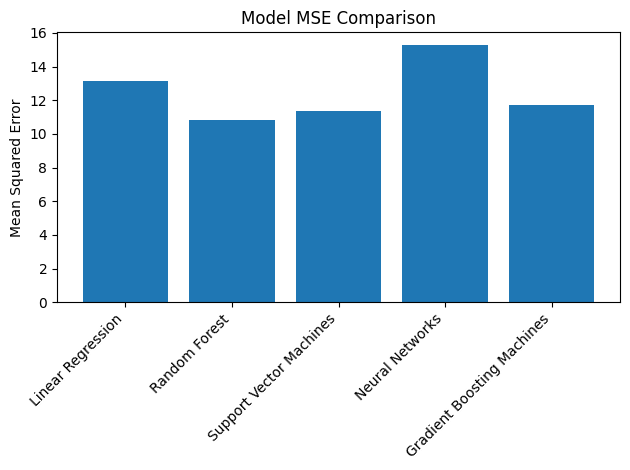

In [20]:
plt.bar(model_names, mse_values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean Squared Error')
plt.title('Model MSE Comparison')
plt.tight_layout()
plt.show()

Random Forest Model has the lowest MSE

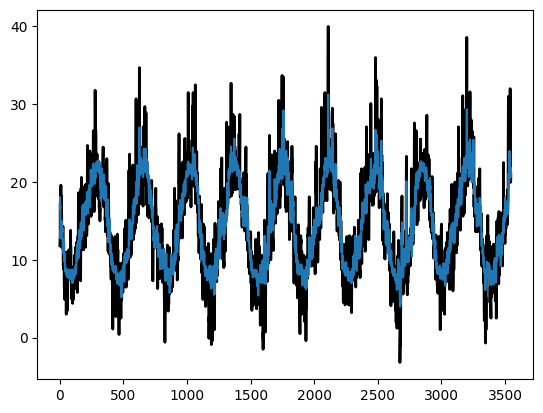

In [21]:
model_rf=RandomForestRegressor().fit(X_train, y_train)
y_pred = model.predict(X)
plt.plot(y, label='True Values', color='black', linewidth=2)
plt.plot(y_pred, label="Predicted")

## Compare the results with ARIMA

<AxesSubplot:xlabel='time'>

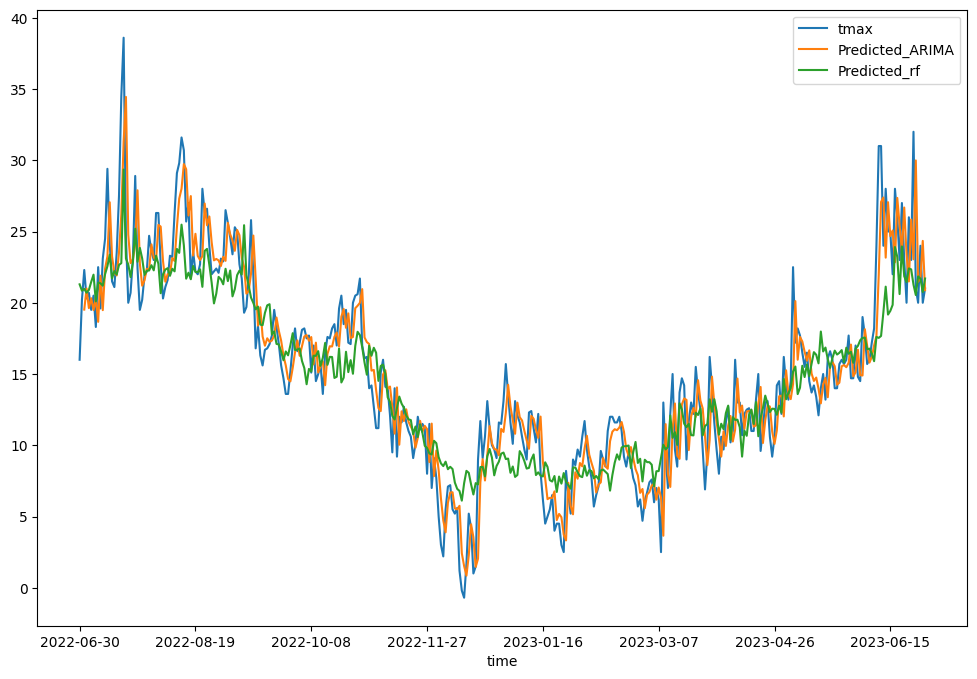

In [22]:
df_tem['Predicted_rf']=y_pred[-366:]
df_tem[['tmax','Predicted_ARIMA','Predicted_rf']].plot(figsize=(12,8))